In [76]:
# Import OMERO Python BlitzGateway
import omero
from omero.gateway import BlitzGateway
import ezomero
# Import Numpy
import numpy as np

# Import Python System Packages
import os
import tempfile
import pandas
import warnings

### Setup connection with OMERO

In [77]:
conn = BlitzGateway(host='localhost', username='root', passwd='omero', secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### Get info from the dataset

In [78]:
datatype = "Dataset" # "plate", "dataset", "image"
data_id = 	502
nucl_channel = 0

#validate that data_id matches datatype
if datatype == "Plate":
    plate = conn.getObject("Plate", data_id)
    print('Plate Name: ', plate.getName())
elif datatype == "Dataset":
    dataset = conn.getObject("Dataset", data_id)
    print('Dataset Name: ', dataset.getName())
elif datatype == "Image":
    image = conn.getObject("Image", data_id)
    print('Image Name: ', image.getName())

Dataset Name:  day7


## Get attachment

In [79]:
#get attachment id from  
annotations = ezomero.get_file_annotation_ids(conn, datatype,data_id)
print(annotations)
df = ezomero.get_table(conn,annotations[0]) #TODO: find the correct folder if there are multiple

#show table summary
print(df.head())

[1491]
   label  original_label  bbox_min_x  bbox_min_y  bbox_min_z  bbox_max_x  \
0      1               1         935         913           0         950   
1      2               2         935         553           0         946   
2      3               3         475          50           0         488   
3      4               4         673         622           0         683   
4      5               5         662         596           0         673   

   bbox_max_y  bbox_max_z  bbox_width  bbox_height  ...  centroid_y  \
0         933           0          16           21  ...  922.914368   
1         568           0          12           16  ...  560.059998   
2          70           0          14           21  ...   59.889866   
3         634           0          11           13  ...  628.471191   
4         607           0          12           12  ...  601.117126   

   sum_distance_to_centroid  mean_distance_to_centroid  \
0               1572.688721                   6.119

### get metadata from OMERO per image


In [80]:
#list columns from table
print(df.columns)
#list unique values from imageID add to list
image_ids = df['imageID'].unique()
metadata = []
for image_id in image_ids:
    file_ann_ids = ezomero.get_map_annotation_ids(conn, 'Image', int(image_id), ns='openmicroscopy.org/omero/experimental/metadata')
    annotation = ezomero.get_map_annotation(conn, file_ann_ids[0])
    annotation.update({"imageID": image_id}) 
    metadata.append(annotation)
#convert metadata list to from list of dict to a pandas dataframe, match the same keys, but check if maybe some keys are missing in some dicts
metadata_df = pandas.DataFrame(metadata)

#join metadata_df to df
df = df.merge(metadata_df, on='imageID', how='left')
print(df.columns)

Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbox_height',
       'bbox_depth', 'min_intensity', 'max_intensity', 'sum_intensity', 'area',
       'sum_intensity_times_z', 'mass_center_z', 'sum_x', 'sum_y', 'sum_z',
       'centroid_z', 'z', 't', 'channel', 'imageID', 'mean_intensity',
       'sum_intensity_times_x', 'mass_center_x', 'sum_intensity_times_y',
       'mass_center_y', 'centroid_x', 'centroid_y', 'sum_distance_to_centroid',
       'mean_distance_to_centroid', 'sum_distance_to_mass_center',
       'mean_distance_to_mass_center', 'standard_deviation_intensity',
       'max_distance_to_centroid', 'max_distance_to_mass_center',
       'mean_max_distance_to_centroid_ratio',
       'mean_max_distance_to_mass_center_ratio'],
      dtype='object')
Index(['label', 'original_label', 'bbox_min_x', 'bbox_min_y', 'bbox_min_z',
       'bbox_max_x', 'bbox_max_y', 'bbox_max_z', 'bbox_width', 'bbo

### Plot data

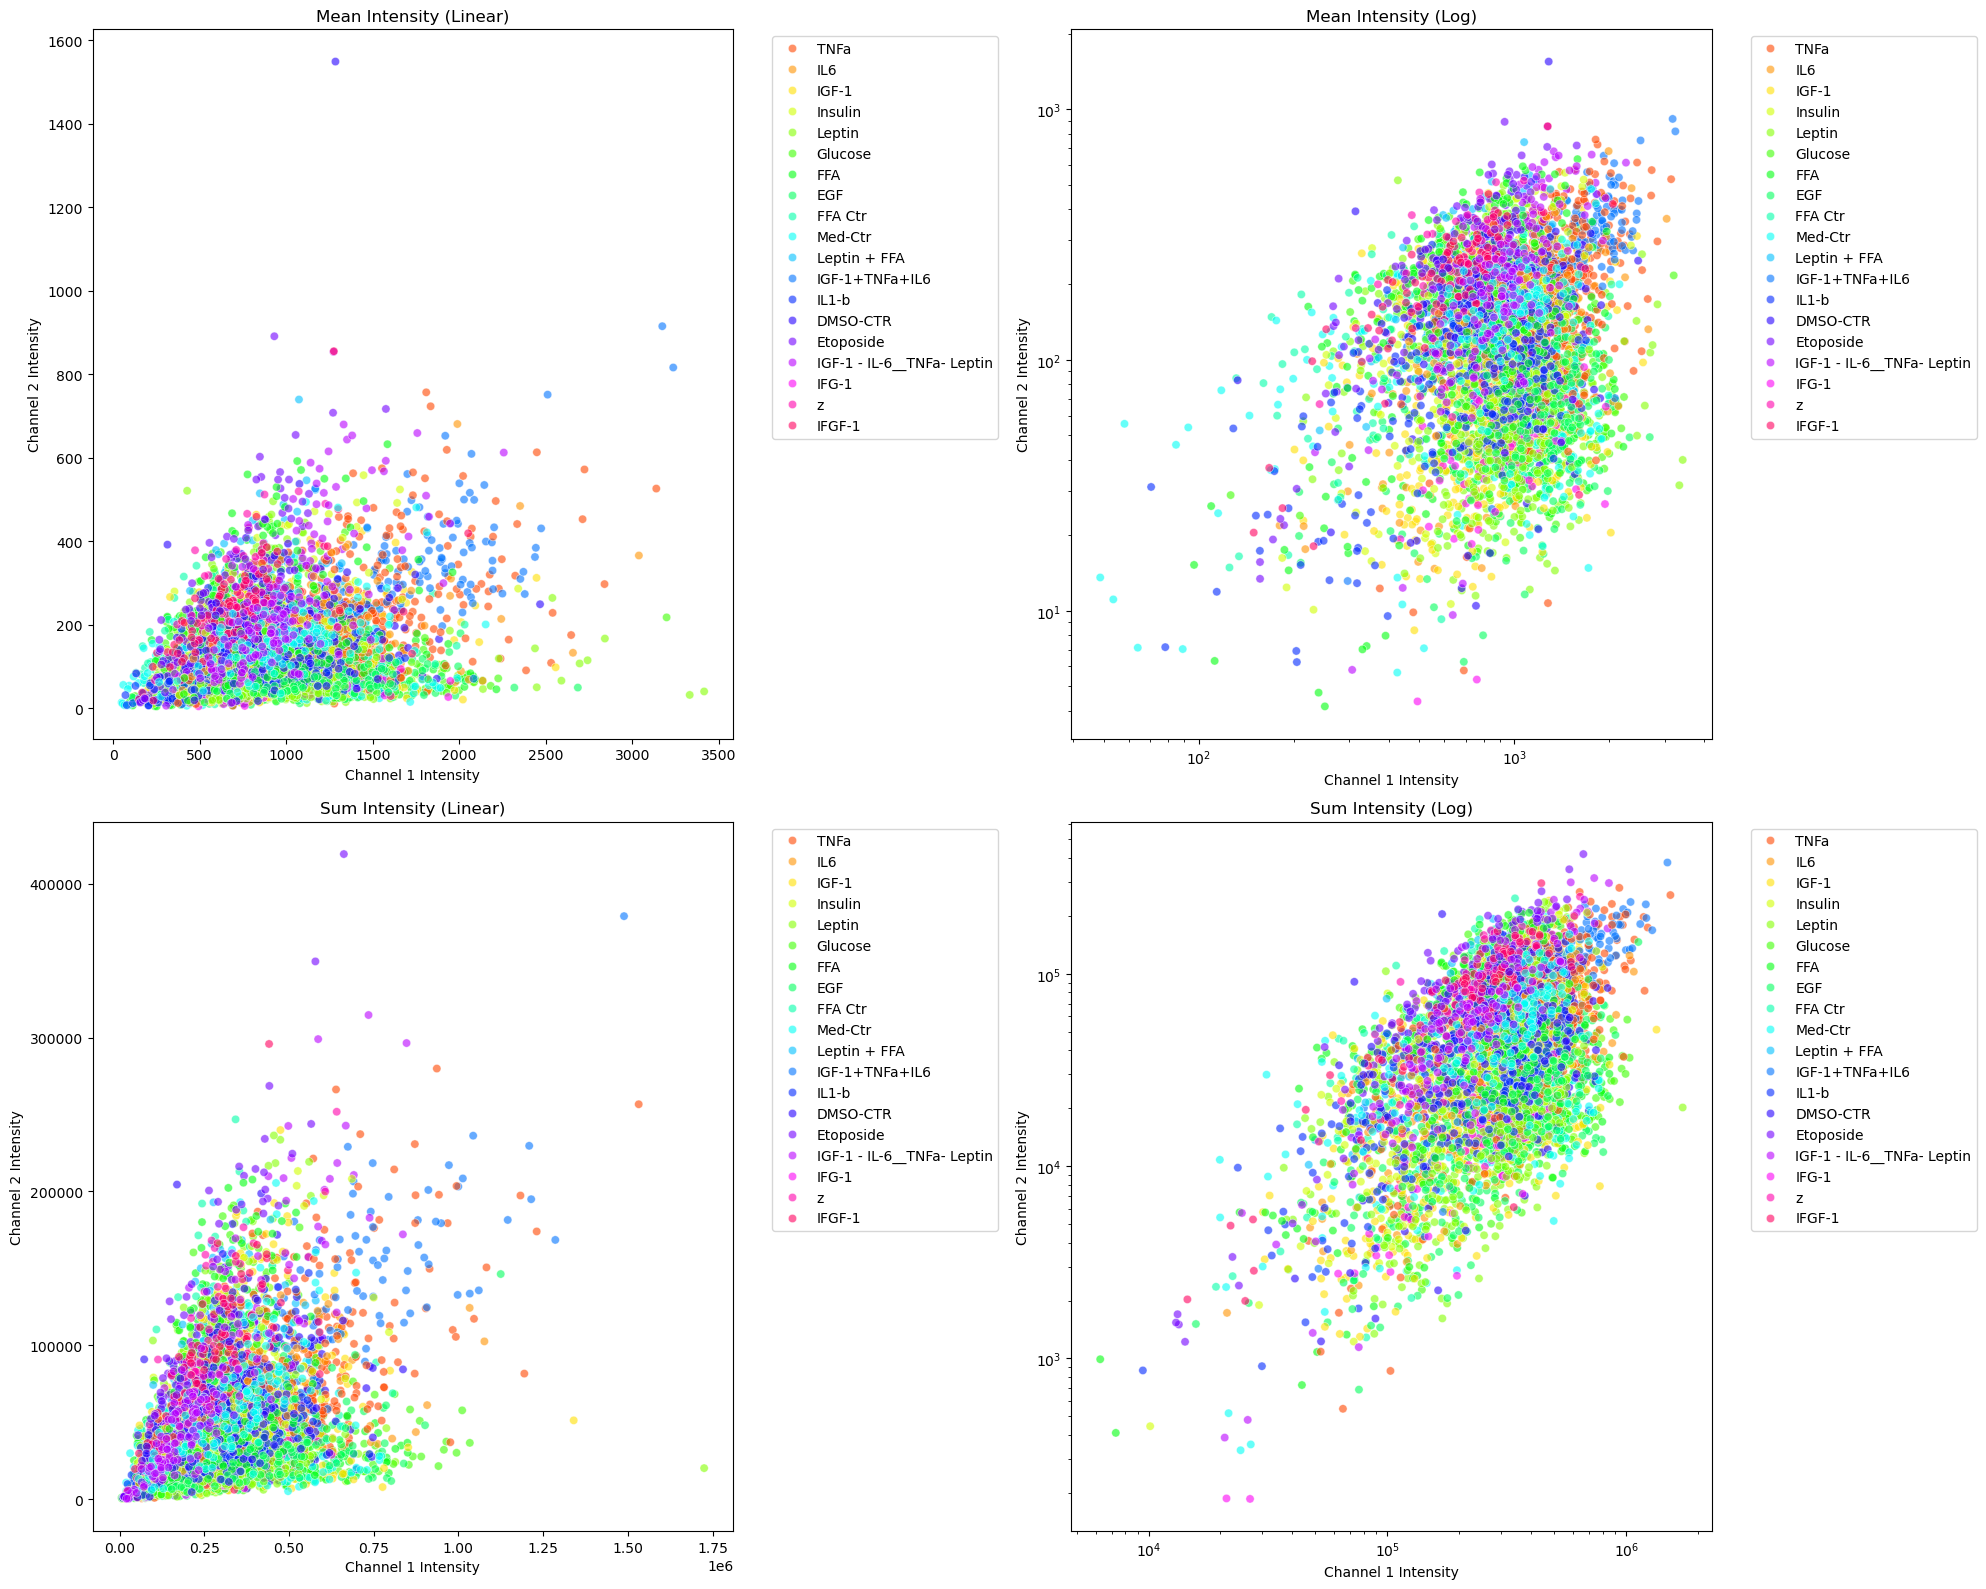

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_intensity_plots(df):
    # Create pivot tables for mean and sum intensities
    pivot_mean = df.pivot_table(
        index=['imageID', 'label', 'Treatment'],
        columns='channel',
        values='mean_intensity'
    ).reset_index()
    
    pivot_sum = df.pivot_table(
        index=['imageID', 'label', 'Treatment'],
        columns='channel',
        values='sum_intensity'
    ).reset_index()
    
    # Rename columns for clarity
    pivot_mean.columns.name = None
    pivot_sum.columns.name = None
    
    pivot_mean = pivot_mean.rename(columns={
        1: 'mean_intensity_ch1',
        2: 'mean_intensity_ch2'
    })
    
    pivot_sum = pivot_sum.rename(columns={
        1: 'sum_intensity_ch1',
        2: 'sum_intensity_ch2'
    })
    
    # Create color palette
    unique_treatments = df['Treatment'].unique()
    palette = dict(zip(unique_treatments, sns.color_palette("hsv", len(unique_treatments))))
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot settings for each subplot
    plot_settings = [
        {'data': pivot_mean, 'x': 'mean_intensity_ch1', 'y': 'mean_intensity_ch2', 'log': False, 'ax': axes[0,0], 'title': 'Mean Intensity (Linear)'},
        {'data': pivot_mean, 'x': 'mean_intensity_ch1', 'y': 'mean_intensity_ch2', 'log': True, 'ax': axes[0,1], 'title': 'Mean Intensity (Log)'},
        {'data': pivot_sum, 'x': 'sum_intensity_ch1', 'y': 'sum_intensity_ch2', 'log': False, 'ax': axes[1,0], 'title': 'Sum Intensity (Linear)'},
        {'data': pivot_sum, 'x': 'sum_intensity_ch1', 'y': 'sum_intensity_ch2', 'log': True, 'ax': axes[1,1], 'title': 'Sum Intensity (Log)'}
    ]
    
    # Create each plot
    for settings in plot_settings:
        ax = settings['ax']
        
        # Create scatter plot
        sns.scatterplot(data=settings['data'], 
                       x=settings['x'], 
                       y=settings['y'], 
                       hue='Treatment', 
                       palette=palette, 
                       alpha=0.6,
                       ax=ax)
        
        # Set scales
        if settings['log']:
            ax.set_xscale('log')
            ax.set_yscale('log')
        
        # Set labels
        ax.set_xlabel('Channel 1 Intensity')
        ax.set_ylabel('Channel 2 Intensity')
        ax.set_title(settings['title'])
        
        # Adjust legend
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Call the function with your dataframe
create_intensity_plots(df)

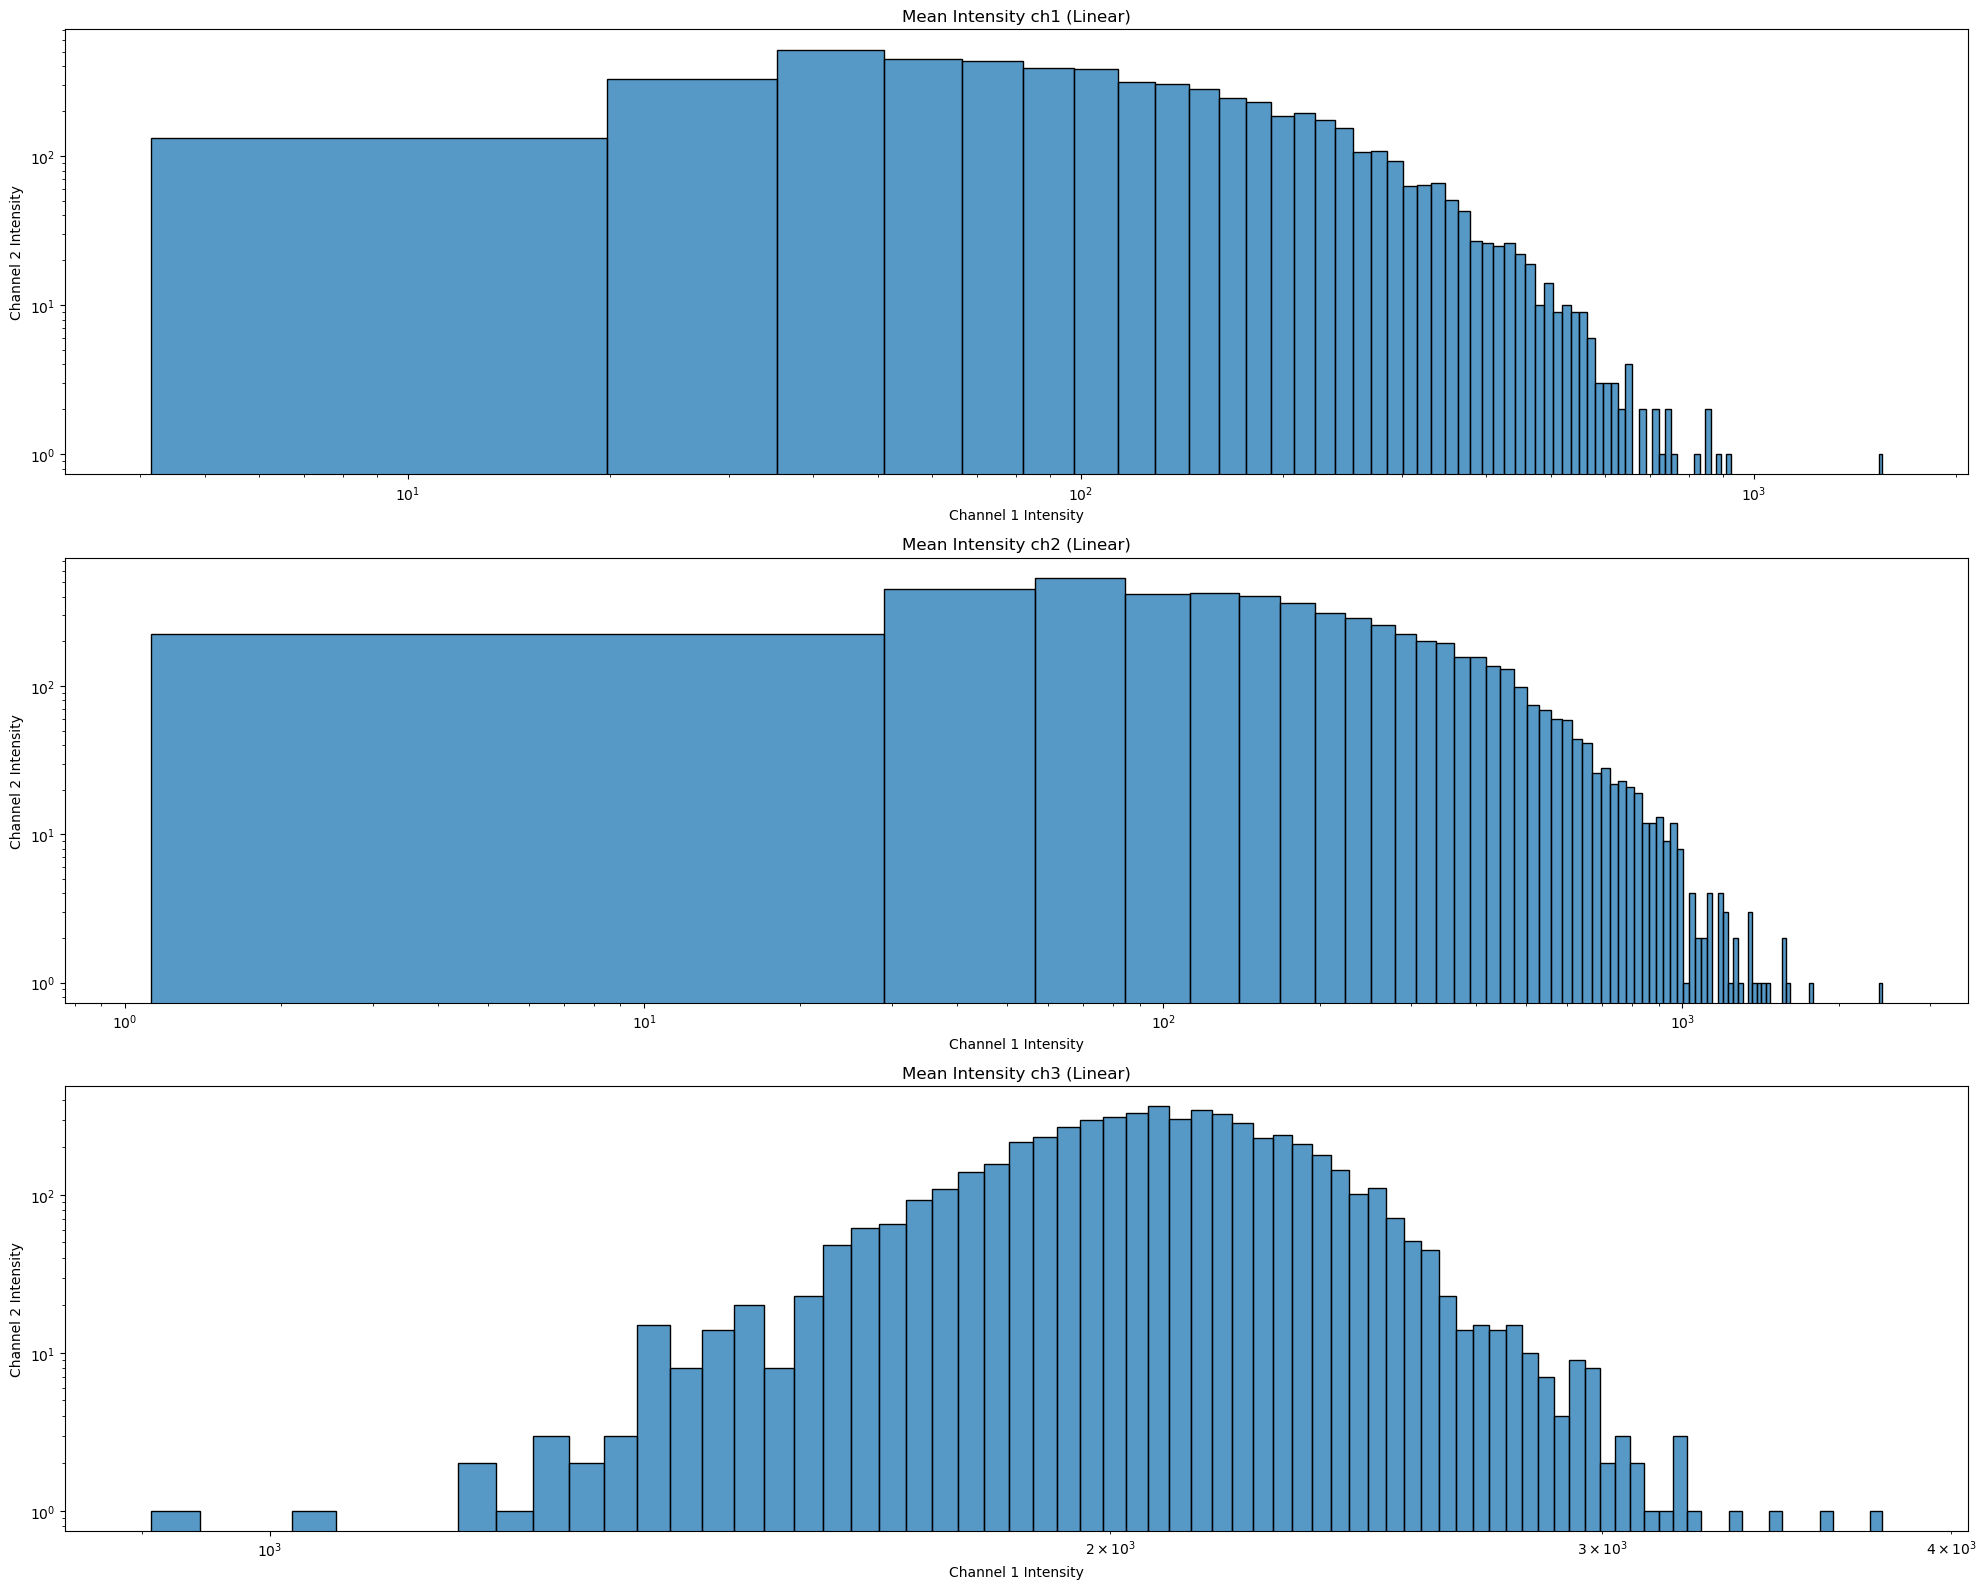

In [ ]:
#plot histogram of mean intensity at the different channels, so 4 plots in total
def create_intensity_histograms(df):
    # Create pivot tables for mean and sum intensities
    pivot_mean = df.pivot_table(
        index=['imageID', 'label', 'Treatment'],
        columns='channel',
        values='mean_intensity'
    ).reset_index()
    
    pivot_sum = df.pivot_table(
        index=['imageID', 'label', 'Treatment'],
        columns='channel',
        values='sum_intensity'
    ).reset_index()
    
    # Rename columns for clarity
    pivot_mean.columns.name = None
    pivot_sum.columns.name = None
    
    pivot_mean = pivot_mean.rename(columns={
        1: 'mean_intensity_ch1',
        2: 'mean_intensity_ch2',
        3: 'mean_intensity_ch3'
    })
    
    pivot_sum = pivot_sum.rename(columns={
        1: 'sum_intensity_ch1',
        2: 'sum_intensity_ch2',
        3: 'sum_intensity_ch3'
    })
    
    # Create color palette
    unique_treatments = df['Treatment'].unique()
    palette = dict(zip(unique_treatments, sns.color_palette("hsv", len(unique_treatments))))
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(3, 1, figsize=(20, 16))
    # Plot settings for each subplot
    plot_settings = [
        {'data': pivot_mean, 'x': 'mean_intensity_ch1',  'log': False, 'ax': axes[0], 'title': 'Mean Intensity ch1 (Linear)'},
        {'data': pivot_mean, 'x': 'mean_intensity_ch2',  'log': False, 'ax': axes[1], 'title': 'Mean Intensity ch2 (Linear)'},
        {'data': pivot_mean, 'x': 'mean_intensity_ch3',  'log': False, 'ax': axes[2], 'title': 'Mean Intensity ch3 (Linear)'}      
    ]
    
    # Create each plot
    for settings in plot_settings:
        ax = settings['ax']
        
        # Create scatter plot
        sns.histplot(data=settings['data'], 
                       x=settings['x'],
                      # y=settings['y'], 
                     #  hue='Treatment', 
                      # palette=palette, 
                     #  alpha=0.6,
                       ax=ax)
        
        # Set scales
        if settings['log']:
            ax.set_xscale('log')
            ax.set_yscale('log')
        
        # Set labels
        ax.set_xlabel('Channel 1 Intensity')
        ax.set_ylabel('Channel 2 Intensity')
        ax.set_title(settings['title'])
        
        # Adjust legend
    #    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Call the function with your dataframe
create_intensity_histograms(df)

C:\Users\mwpaul\AppData\Local\Temp\ipykernel_7340\1811154508.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


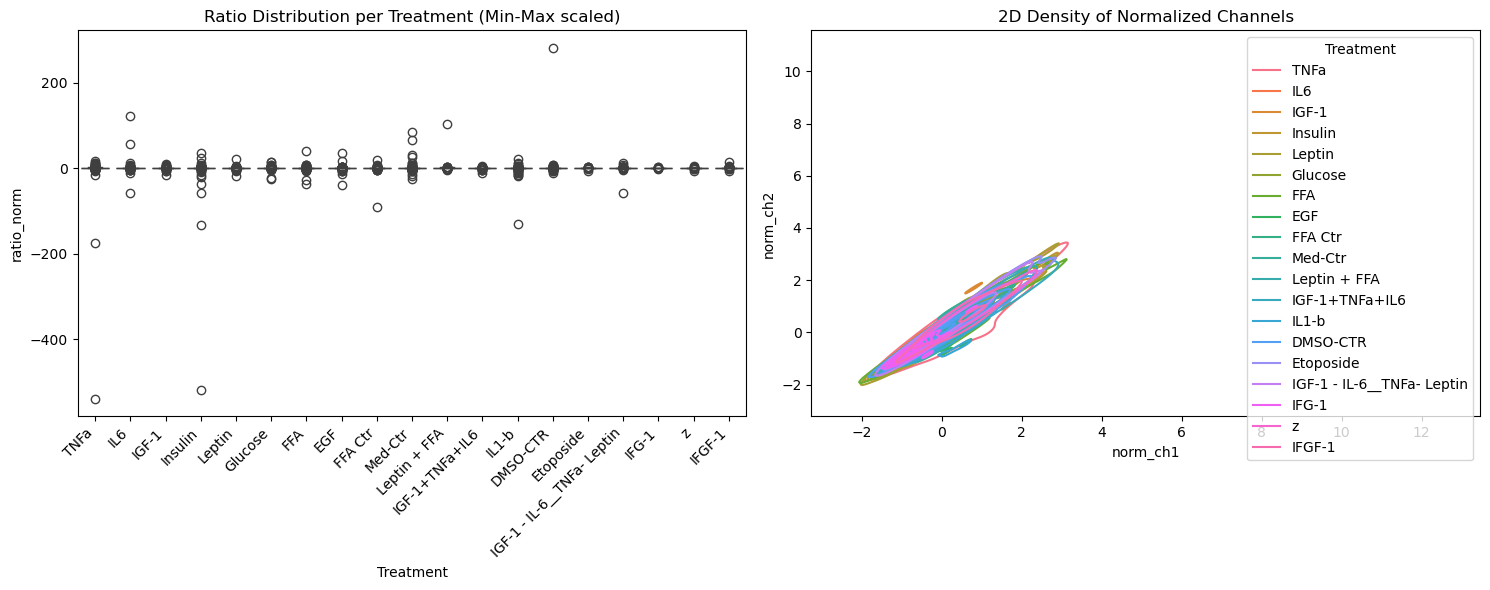

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First normalize the intensities for each channel
# Method 1: Z-score normalization per channel
pivot_df['norm_ch1'] = (pivot_df['mean_intensity_ch1'] - pivot_df['mean_intensity_ch1'].mean()) / pivot_df['mean_intensity_ch1'].std()
pivot_df['norm_ch2'] = (pivot_df['mean_intensity_ch2'] - pivot_df['mean_intensity_ch2'].mean()) / pivot_df['mean_intensity_ch2'].std()

# Method 2: Min-Max scaling per channel
pivot_df['scaled_ch1'] = (pivot_df['mean_intensity_ch1'] - pivot_df['mean_intensity_ch1'].min()) / (pivot_df['mean_intensity_ch1'].max() - pivot_df['mean_intensity_ch1'].min())
pivot_df['scaled_ch2'] = (pivot_df['mean_intensity_ch2'] - pivot_df['mean_intensity_ch2'].min()) / (pivot_df['mean_intensity_ch2'].max() - pivot_df['mean_intensity_ch2'].min())

# Calculate ratios
pivot_df['ratio_norm'] = pivot_df['norm_ch2'] / pivot_df['norm_ch1']
pivot_df['ratio_scaled'] = pivot_df['scaled_ch2'] / pivot_df['scaled_ch1']

# Create visualization of the ratios
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot density of ratios per treatment
sns.boxplot(data=pivot_df, x='Treatment', y='ratio_norm', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Ratio Distribution per Treatment (Min-Max scaled)')

# Create 2D density plot of normalized channels
sns.kdeplot(data=pivot_df, x='norm_ch1', y='norm_ch2', hue='Treatment', ax=ax2)
ax2.set_title('2D Density of Normalized Channels')

plt.tight_layout()
plt.show()